In [21]:
import sys
import os
import argparse
import logging
import json
import time
import cv2

import numpy as np
import torch
import pickle
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import BCEWithLogitsLoss, BCELoss ,CrossEntropyLoss
from torch.optim import SGD
from torchvision import models
from torch import nn

from tqdm import tqdm
from tensorboardX import SummaryWriter
from imagedataset import ImageDataset, WSIimageDataset, GradeImageDataset, tumorImageDataset
from testloader import WSIimageDataset
from clsmodels.models import create_model
from clsmodels import resnet_fpn
from sklearn.metrics import roc_curve, auc, confusion_matrix
import itertools
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
slist = np.load('fin.npy')
with open('cftestnf.json','r') as f:
    cf = json.load(f)
slidelist2 = []
for slide in slist:
    if slide in cf:
        slidelist2.append(slide)

In [4]:
model = resnet_fpn.resnet34_fpn_classifier(num_classes=[2,2,2],pretrained = True)
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load('temp/checkpoints/bestmodel/resnet34_fpn_classifier_14_3.pth.tar'))
loss_fn = CrossEntropyLoss().cuda()
#loss_fn = BCELoss().cuda()

model.eval()

preds_nf = np.zeros(len(slidelist2))
preds_ncr = np.zeros(len(slidelist2))
preds_shape = np.zeros(len(slidelist2))

for i in range(len(slidelist2)):
    slide = slidelist2[i]
    print(slide)
    testdataset = WSIimageDataset(slide,1)
    testdataloader = DataLoader(testdataset,batch_size = 32,drop_last = True)

    labels = cf[slide]
    preds1 = []
    preds2 = []
    preds3 = []


    progress_bar = tqdm(enumerate(testdataloader),total = len(testdataloader))
    for iter_num,data in progress_bar:
        img = data
        img = img.cuda().float()
        #label_nf = label_nf.cuda().float()
        #label_shape = label_shape.cuda().float()
        output1,output2,output3 = model(img)

        output1 = torch.squeeze(output1)
        output2 = torch.squeeze(output2)
        output3 = torch.squeeze(output3)


        pred_nf = output1.argmax(axis=1)
        pred_ncr = output2.argmax(axis=1)
        pred_shape = output3.argmax(axis=1)

        #prob2 = output2.sigmoid()

        #print(pred_shape)
        #print(label_shape.argmax(axis=1))

        preds1.extend(np.array(pred_nf.cpu()).tolist())
        preds2.extend(np.array(pred_ncr.cpu()).tolist())
        preds3.extend(np.array(pred_shape.cpu()).tolist())


        progress_bar.set_description(f'test {slide}')

    rate1 = np.sum(preds1)/len(preds1)
    rate2 = np.sum(preds2)/len(preds2)
    rate3 = np.sum(preds3)/len(preds3)
    #print(rate1,rate2,rate3)
    if rate1 > 0.5:
        preds_nf[i] = 1
    if rate2 > 0.5:
        preds_ncr[i] = 1
    if rate3 > 0.5:
        preds_shape[i] = 1
labels_nfname = ['轻度','显著']
labels_ncrname = ['增大','很大']
labels_shapename = ['粗梁实性','粗梁实性和假腺状']

preds_ncr = preds_ncr.astype(np.int)
preds_nf = preds_nf.astype(np.int)
preds_shape = preds_shape.astype(np.int)

#print('==> generate pathological description')
#for i in range(len(slidelist2)):
#    print(f'slide id: {slidelist2[i]}')
#    print(f'该切片细胞核深染{labels_nfname[preds_nf[i]]},核质比{labels_ncrname[preds_ncr[i]]},肿瘤区域细胞主要呈{labels_shapename[preds_shape[i]]}排列。')

  0%|          | 0/3 [00:00<?, ?it/s]

201434013-4


  0%|          | 0/3 [00:00<?, ?it/s]

201603238-2


  0%|          | 0/3 [00:00<?, ?it/s]

201608537-4


  0%|          | 0/3 [00:00<?, ?it/s]

201434822-2


  0%|          | 0/3 [00:00<?, ?it/s]

201603916-3


test 201603916-3: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


In [7]:
slidename = slidelist2[1]
slidename

'201603238-2'

In [77]:
imgpath = 'zipimgs/'+slidelist2[2] + '.jpg'
img = Image.open(imgpath)

In [86]:
imgary = np.array(img)
imgary.shape

(4468, 2006, 3)

In [83]:
## 处理黑色的区域
X,Y = np.where(imgary[:,:,0]<10)

In [84]:
imgary[X,Y,:] = 255

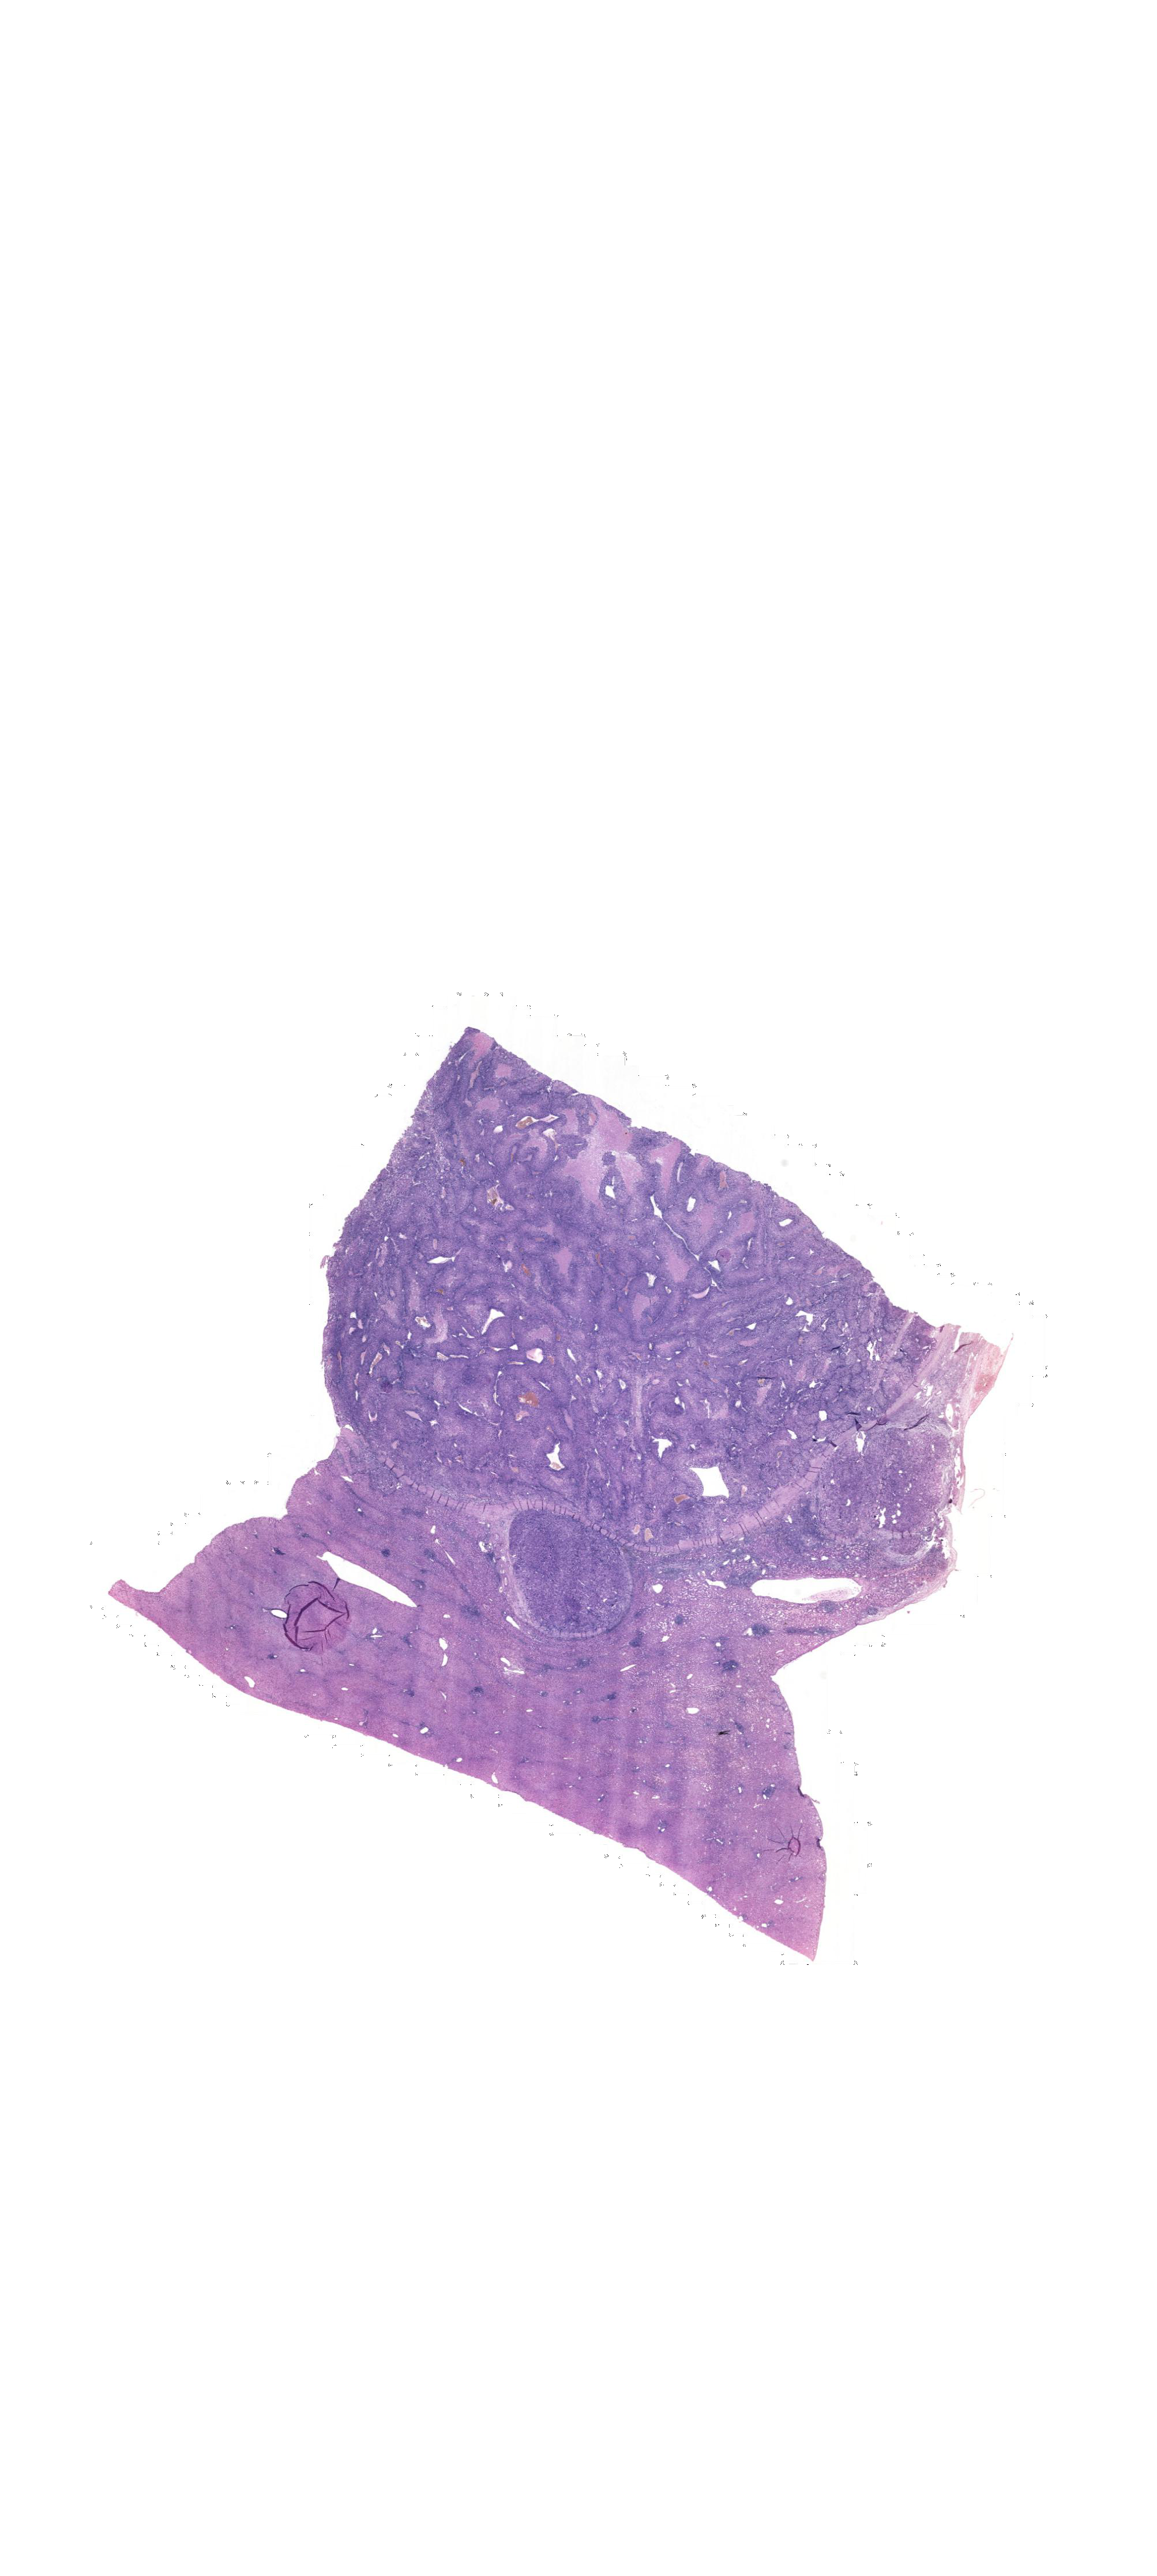

In [85]:
Image.fromarray(imgary)

In [51]:
i = 2
des = f'该切片细胞核深染{labels_nfname[preds_nf[i]]},核质比{labels_ncrname[preds_ncr[i]]},肿瘤区域细胞主要呈{labels_shapename[preds_shape[i]]}排列。'

In [52]:
des

'该切片细胞核深染显著,核质比很大,肿瘤区域细胞主要呈粗梁实性排列。'

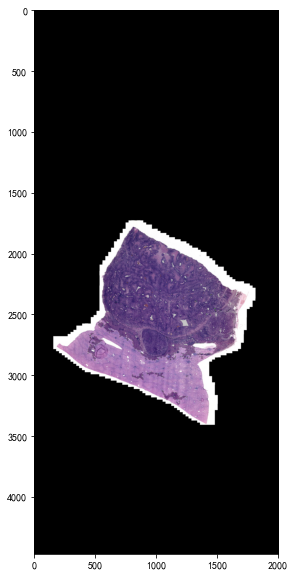

In [89]:
plt.figure(figsize=(20,10))

plt.imshow(imgary+maskpro)

plt.show()


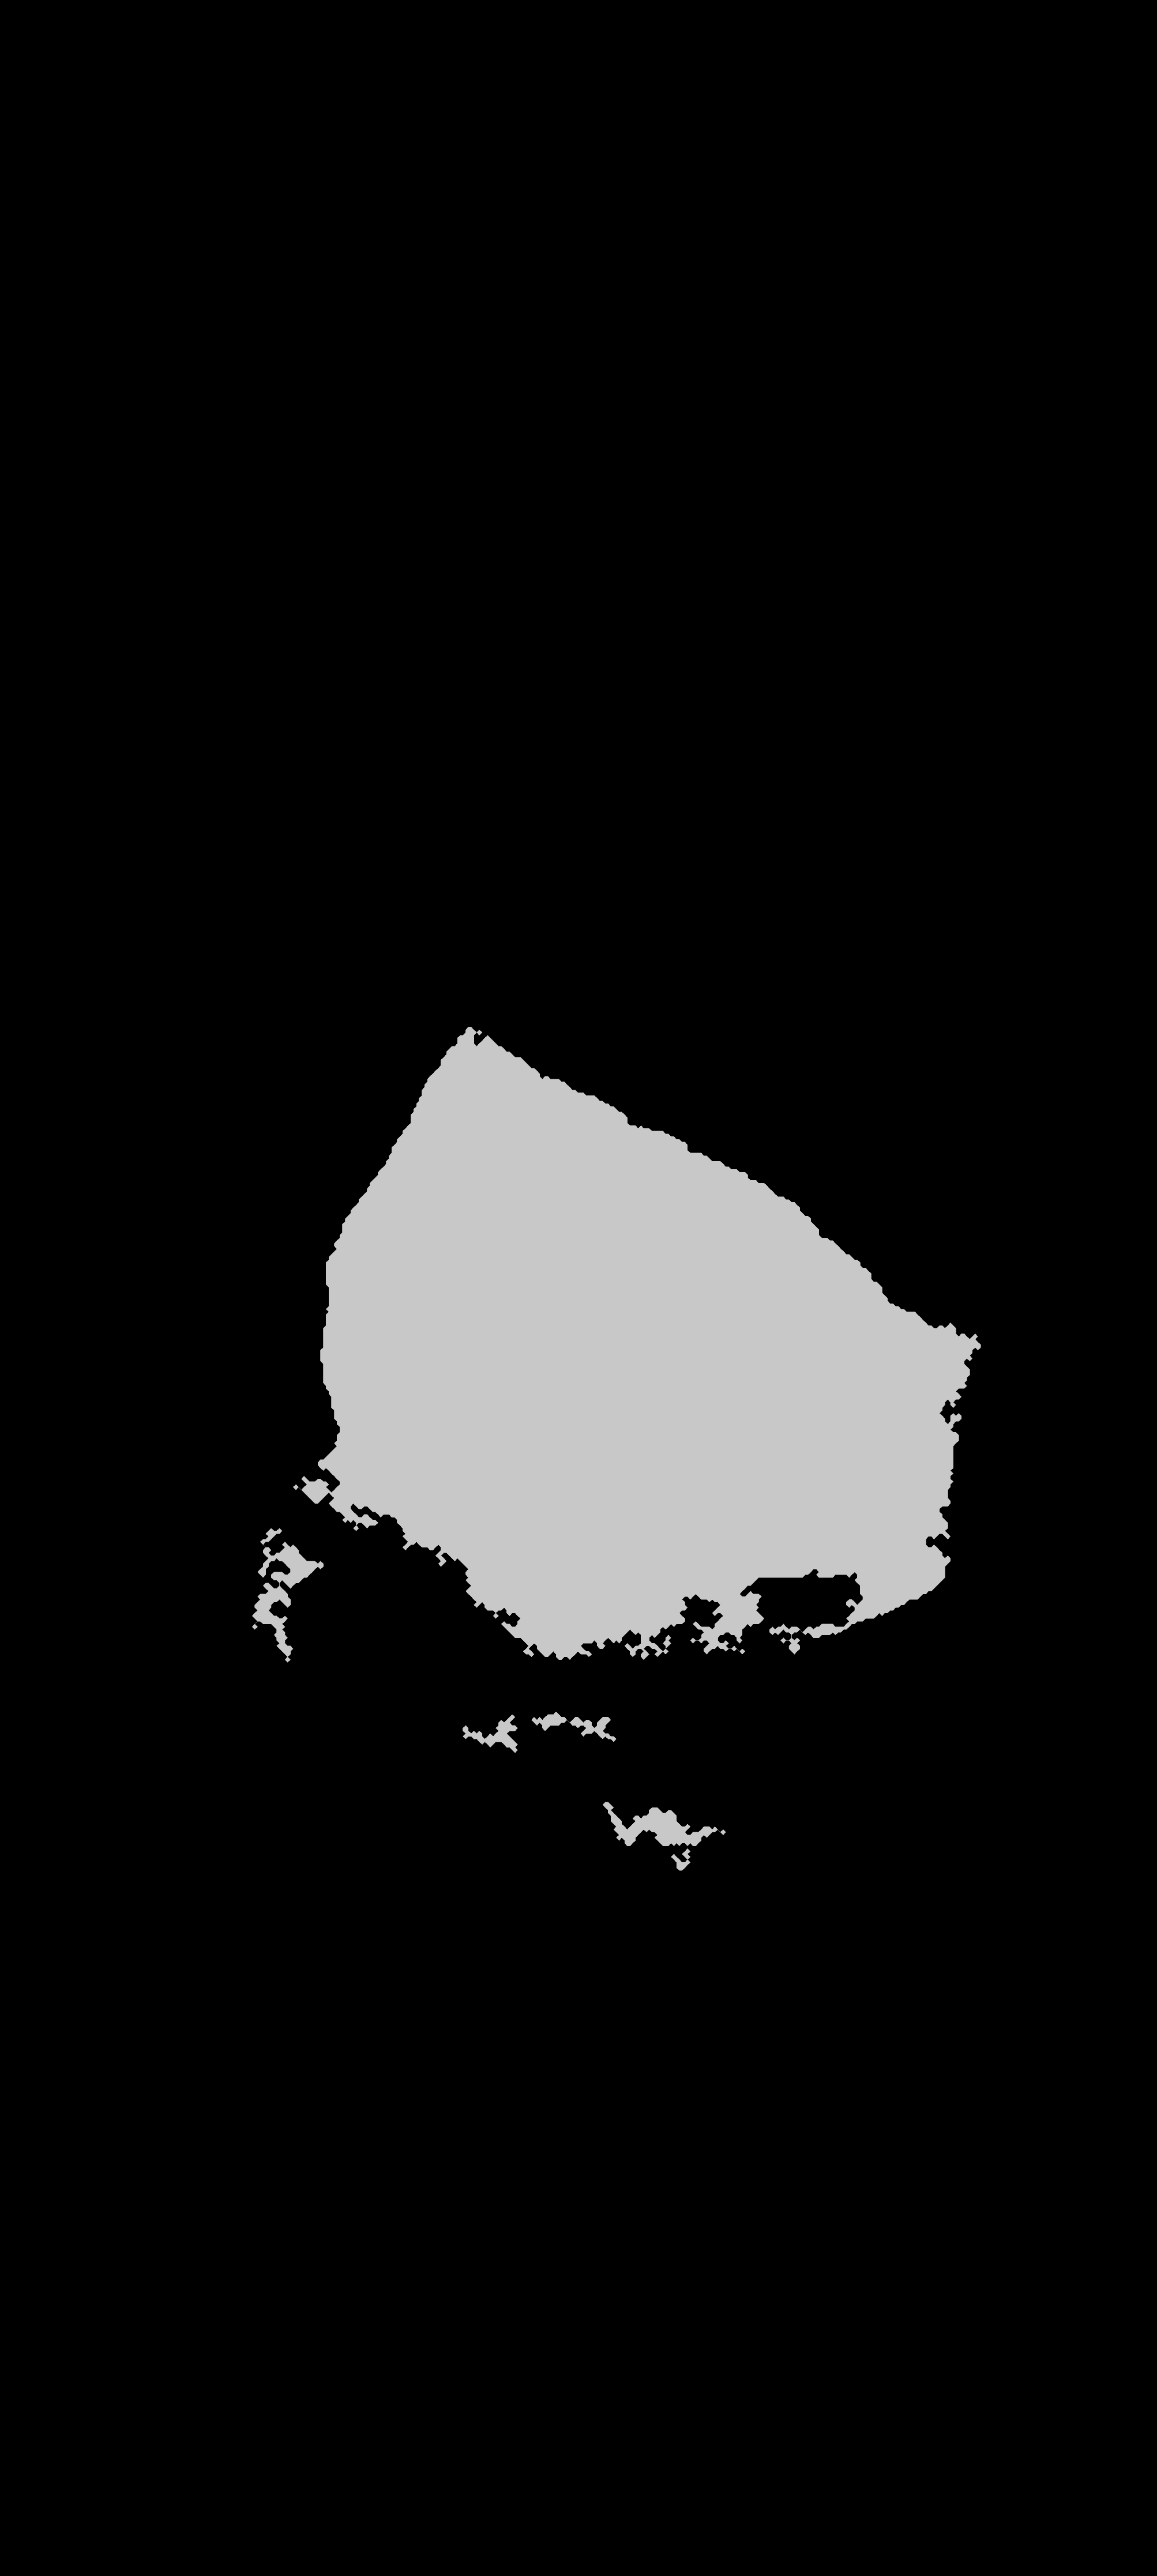

In [87]:
maskpath = 'patchdata/'+slidelist2[2]+'/'+'mask.npy'
mask = np.load(maskpath)
maskpro = mask.astype(np.uint8)*2
maskpro = np.array([maskpro for i in range(3)]).transpose(1,2,0)
maskpro = cv2.resize(maskpro,dsize=(int(mask.shape[1]/2),int(mask.shape[0]/2)))
X,Y = np.where(maskpro[:,:,0])
maskpro = maskpro.transpose(1,0,2)
#Image.fromarray(maskpro)

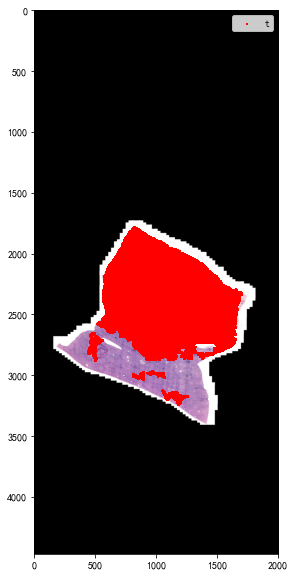

In [65]:
plt.figure(figsize=(20,10))

plt.imshow(img)
plt.scatter(X,Y,s=1,marker=',',c='r')

plt.show()

In [67]:
slidelist2

['201434013-4', '201603238-2', '201608537-4', '201434822-2', '201603916-3']

In [75]:
preds = {}
for i in range(5):
    preds[slidelist2[i]] = []
    preds[slidelist2[i]].append(int(preds_nf[i]))
    preds[slidelist2[i]].append(int(preds_ncr[i]))
    preds[slidelist2[i]].append(int(preds_shape[i]))

In [76]:
with open('preds.json','w') as f:
    json.dump(preds,f)

In [71]:
preds

{'201434013-4': [1, 0, 0],
 '201603238-2': [0, 0, 1],
 '201608537-4': [1, 1, 0],
 '201434822-2': [0, 0, 1],
 '201603916-3': [1, 1, 0]}

In [69]:
preds = {}
preds['nf'] = preds_nf
preds['ncr'] = preds_ncr
preds['shape'] = preds

array([0, 0, 1, 0, 1])

In [73]:
preds_shape

array([0, 1, 0, 1, 0])